In [177]:
# deal with some cruft on my machine
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

load tools

In [178]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pk
import censusdata
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

A Census Block Group is a geographical unit used by the United States Census Bureau which is between the Census Tract and the Census Block. It is the smallest geographical unit for which the bureau publishes sample data, i.e. data which is only collected from a fraction of all households.

In [179]:
buncombe_bgs = censusdata.geographies(censusdata.censusgeo([('state', '37'), ('county', '021'),('block group', '*')]), 'acs5', '2015')

In [180]:
print("number of block groups {}".format(len(buncombe_bgs)))

number of block groups 154



Now that we have identified the variables and geographies of interest, we can download the data using censusdata.download and compute variables for the percent unemployed and the percent with no high school degree. This code comes from the example. Note we are pulling 2015 data.

In [181]:
buncombebg = censusdata.download('acs5', '2015',
                             censusdata.censusgeo([('state', '37'), ('county', '021'), ('block group', '*')]),
                             ['B23025_003E', 'B23025_005E', 'B15003_001E', 'B15003_002E', 'B15003_003E',
                              'B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E',
                              'B15003_009E', 'B15003_010E', 'B15003_011E', 'B15003_012E', 'B15003_013E',
                              'B15003_014E', 'B15003_015E', 'B15003_016E'])
buncombebg['percent_unemployed'] = buncombebg.B23025_005E / buncombebg.B23025_003E * 100
buncombebg['percent_nohs'] = (buncombebg.B15003_002E + buncombebg.B15003_003E + buncombebg.B15003_004E
                          + buncombebg.B15003_005E + buncombebg.B15003_006E + buncombebg.B15003_007E + buncombebg.B15003_008E
                          + buncombebg.B15003_009E + buncombebg.B15003_010E + buncombebg.B15003_011E + buncombebg.B15003_012E
                          + buncombebg.B15003_013E + buncombebg.B15003_014E +
                          buncombebg.B15003_015E + buncombebg.B15003_016E) / buncombebg.B15003_001E * 100
buncombebg = buncombebg[['percent_unemployed', 'percent_nohs']]

save data to pickle file for exploration and modeling

In [182]:
buncombebg.to_pickle('uemp_nohs.pk')

In [183]:
buncombebg['FIPS'] = buncombebg.index.astype(str)
buncombebg['FIPS'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
buncombebg['FIPS'].astype(str)
buncombebg['FIPS'] = buncombebg['FIPS'].str[-12:]
buncombebg.index = buncombebg['FIPS']
#buncombebg

In [184]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
%matplotlib inline


In [185]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import shapefile
from shapely.geometry import shape
import osr

zipped_shp_url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_37_bg_500k.zip'

zipfile = ZipFile(BytesIO(urlopen(zipped_shp_url).read()))
filenames = [y for y in sorted(zipfile.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [BytesIO(zipfile.read(filename)) for filename in filenames]
r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)
    
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  
    
        
proj4_string = osr.SpatialReference(prj.read().decode("utf-8") ).ExportToProj4()
all_nc_tract_geo = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)

buncombe_tract_geo = all_nc_tract_geo[all_ca_tract_geo.COUNTYFP=='021']
buncombe_tract_geo = buncombe_tract_geo.set_index("GEOID")['geometry'].to_crs(epsg=3395)
#buncombe_tract_geo


Text(0.5,1,'Buncombe County, NC - Unemployment by Census Block Group')

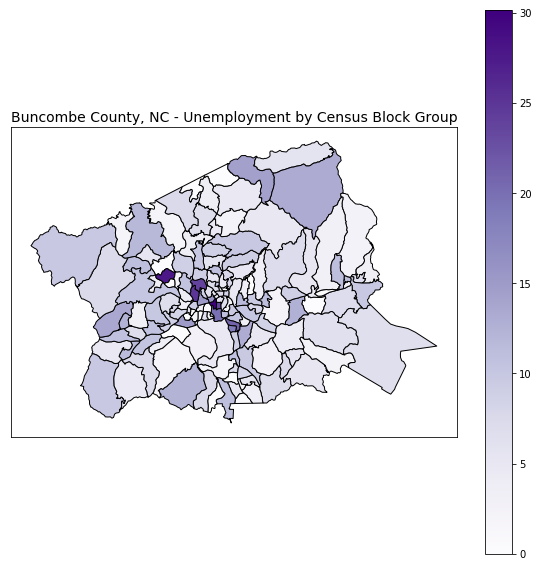

In [186]:
buncombe_gdf = gpd.GeoDataFrame(geometry = buncombe_tract_geo, data = buncombebg)
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
alameda_gdf.plot(column= 'percent_unemployed', ax = ax, cmap='Purples', legend=True, edgecolor='black')
plt.title('Buncombe County, NC - Unemployment by Census Block Group', size = 14)
